In [5]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.makedirs('/root/.kaggle', exist_ok=True)
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions list

!kaggle competitions download -c playground-series-s5e8

!unzip playground-series-s5e8.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2025                               2025-11-03 23:59:00  Featured         1,000,000 Usd        769           False  
https://www.kaggle.com/competitions/google-gemma-3n-hackathon                    2025-08-06 23:59:00  Featured           150,000 Usd          0           False  
https://www.kaggle.com/competitions/make-data-count-finding-data-references      2025-09-09 23:59:00  Research           100,000 Usd        887           False  
https://www.kaggle.com/competitions/jigsaw-agile-community-ru

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [28]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')
print(train.shape)
print(test.shape)
train.head()

(750000, 17)
(250000, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


### Dataset handling

In [ ]:
for i in train.columns:
  print(f'{i}:')
  print(train[i].unique())
  print('\n')

age:
[42 38 36 27 26 24 39 50 46 32 37 57 33 47 35 49 77 40 54 56 51 30 67 58
 59 45 43 29 48 31 28 34 60 52 41 81 23 62 53 72 55 25 44 61 63 69 75 71
 64 22 83 70 80 21 65 74 68 19 73 66 79 20 84 86 76 18 82 78 87 85 88 94
 93 89 92 95 90 91]


job:
['technician' 'blue-collar' 'student' 'admin.' 'management' 'entrepreneur'
 'self-employed' 'unknown' 'services' 'retired' 'housemaid' 'unemployed']


marital:
['married' 'single' 'divorced']


education:
['secondary' 'primary' 'tertiary' 'unknown']


default:
['no' 'yes']


balance:
[    7   514   602 ... 13023  4003  8218]


housing:
['no' 'yes']


loan:
['no' 'yes']


contact:
['cellular' 'unknown' 'telephone']


day:
[25 18 14 28  3 20 21 31  4  8  5 24 11 12 26 30  6 10 19 17  2 13 29 23
 27  7  9 16  1 22 15]


month:
['aug' 'jun' 'may' 'feb' 'apr' 'nov' 'jul' 'jan' 'oct' 'mar' 'sep' 'dec']


duration:
[ 117  185  111 ... 4817 2455 2040]


campaign:
[ 3  1  2 25  5  7  4 11  6  9  8 16 10 15 12 13 19 17 14 22 23 34 18 29
 24 30 21 27

In [ ]:
train.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [ ]:
train.isna().any().any()

np.False_

In [ ]:
train.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [ ]:
train.housing.unique()

array(['no', 'yes'], dtype=object)

In [ ]:
train.astype({'housing': str, 'age': np.float64}).dtypes

,0
age,float64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [ ]:
grouped_train = train.groupby(by=['job', 'education', 'age']).size().reset_index(name="count")#[train.job=='admin.']

In [ ]:
merged = pd.merge(train, grouped_train)
#pd.merge(train, grouped_train)[(train.job=='admin.') & (train.education=='secondary')]
merged[(merged['job']=='admin.') & (merged['education']=='secondary')]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,count
5,24,admin.,single,secondary,no,1882,yes,no,cellular,20,apr,1010,3,-1,0,unknown,0,513
7,50,admin.,single,secondary,no,1595,no,no,telephone,31,jul,49,25,-1,0,unknown,0,1593
38,46,admin.,married,secondary,no,-314,yes,no,cellular,18,may,66,3,-1,0,unknown,0,2133
42,59,admin.,married,secondary,no,2338,no,no,cellular,10,mar,472,1,90,3,success,1,725
57,46,admin.,married,secondary,no,1527,no,no,cellular,14,aug,391,1,-1,0,unknown,1,2133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749961,57,admin.,divorced,secondary,no,18268,yes,no,unknown,16,may,67,1,-1,0,unknown,0,991
749962,45,admin.,married,secondary,no,-98,no,yes,cellular,11,aug,79,5,-1,0,unknown,0,2328
749972,20,admin.,single,secondary,no,-302,yes,yes,unknown,28,may,132,1,-1,0,unknown,0,13
749980,42,admin.,married,secondary,no,576,yes,no,unknown,7,may,114,2,-1,0,unknown,0,1982


In [ ]:
train.y.value_counts()

,count
y,
0,659512
1,90488


In [ ]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [ ]:
train_big = train[(train['default']=='yes') & (train.marital=='married')].drop(['marital', 'default'], axis=1).sort_values(['age', 'contact', 'job'])
print(train_big.shape)
train_big.head()

(7719, 15)


,age,job,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,
639161,19,services,secondary,-1,no,yes,cellular,31,jul,13,25,-1,0,unknown,0
505431,21,blue-collar,primary,-172,yes,yes,cellular,11,aug,300,1,-1,0,unknown,0
523952,21,blue-collar,secondary,-172,yes,no,unknown,23,may,132,16,-1,0,unknown,0
678336,23,services,secondary,-1270,yes,no,cellular,21,jul,122,7,-1,0,unknown,0
503703,23,management,tertiary,1135,yes,no,unknown,26,jun,471,2,-1,0,unknown,0


In [ ]:
train_1 = train_big.iloc[(train_big.index<600000) & (train_big.index>500000)].drop(['pdays', 'previous', 'poutcome'], axis=1)
train_1

,age,job,education,balance,housing,loan,contact,day,month,duration,campaign,y
id,,,,,,,,,,,,
505431,21,blue-collar,primary,-172,yes,yes,cellular,11,aug,300,1,0
523952,21,blue-collar,secondary,-172,yes,no,unknown,23,may,132,16,0
503703,23,management,tertiary,1135,yes,no,unknown,26,jun,471,2,0
503415,23,services,secondary,-122,yes,no,unknown,2,jun,1018,1,1
519701,24,services,secondary,2279,no,yes,cellular,30,jul,699,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
552203,59,retired,secondary,-938,yes,yes,unknown,28,may,61,1,0
572646,60,technician,secondary,-123,no,no,cellular,20,aug,885,4,1
569399,60,retired,primary,0,no,yes,telephone,10,jul,133,6,0


In [ ]:
train_2 = train_big.iloc[(train_big.index<710000) & (train_big.index>590000)].drop(['housing', 'loan', 'month'], axis=1)
train_2

,age,job,education,balance,contact,day,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,
639161,19,services,secondary,-1,cellular,31,13,25,-1,0,unknown,0
678336,23,services,secondary,-1270,cellular,21,122,7,-1,0,unknown,0
634977,23,technician,secondary,-1083,unknown,28,74,3,-1,0,unknown,0
703801,24,blue-collar,secondary,-254,unknown,27,290,2,-1,0,unknown,0
665074,25,admin.,secondary,0,cellular,21,71,10,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
603363,60,technician,tertiary,-10,cellular,8,633,15,-1,0,unknown,0
623372,60,technician,primary,-16,cellular,8,84,2,-1,0,unknown,0
708447,60,entrepreneur,tertiary,-98,unknown,16,454,2,-1,0,unknown,0


In [ ]:
merged_big = pd.merge(train_1, train_2)
merged_big

,age,job,education,balance,housing,loan,contact,day,month,duration,campaign,y,pdays,previous,poutcome
0,27,unemployed,secondary,-517,yes,no,cellular,22,jul,89,1,0,-1,0,unknown
1,28,management,secondary,130,no,no,cellular,26,may,143,1,0,-1,0,unknown
2,29,self-employed,tertiary,-228,yes,no,cellular,15,may,144,1,0,361,3,failure
3,29,blue-collar,secondary,36,yes,no,unknown,3,jun,178,1,0,-1,0,unknown
4,30,services,secondary,-204,yes,no,cellular,13,may,103,1,0,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,57,entrepreneur,secondary,4,no,yes,cellular,29,jul,227,2,0,-1,0,unknown
110,57,retired,secondary,-5,no,no,cellular,14,jul,118,3,0,-1,0,unknown
111,57,retired,secondary,2,yes,no,unknown,14,may,107,2,0,-1,0,unknown
112,58,management,primary,32,no,yes,cellular,8,jul,85,3,0,-1,0,unknown


In [ ]:
concated = pd.concat([train_1, train_2], axis=1)
#concated.drop_duplicates(concated.columns[2])#'education', axis=1)
concated.loc[:, ~concated.columns.duplicated()]

,age,job,education,balance,housing,loan,contact,day,month,duration,campaign,y,pdays,previous,poutcome
id,,,,,,,,,,,,,,,
505431,21.0,blue-collar,primary,-172.0,yes,yes,cellular,11.0,aug,300.0,1.0,0.0,NaN,NaN,NaN
523952,21.0,blue-collar,secondary,-172.0,yes,no,unknown,23.0,may,132.0,16.0,0.0,NaN,NaN,NaN
503703,23.0,management,tertiary,1135.0,yes,no,unknown,26.0,jun,471.0,2.0,0.0,NaN,NaN,NaN
503415,23.0,services,secondary,-122.0,yes,no,unknown,2.0,jun,1018.0,1.0,1.0,NaN,NaN,NaN
519701,24.0,services,secondary,2279.0,no,yes,cellular,30.0,jul,699.0,3.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,unknown
623372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,unknown
708447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,unknown


In [ ]:
def mapper(x: int) -> int:
  if x<100:
    return 0
  elif (x>=100) & (x<500):
    return 1
  else:
    return 2

train['balance_tier'] = train.balance.apply(lambda x: mapper(x))
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,balance_tier
id,,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0,2
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0,2
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1,2
749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0,2
749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0,1


In [ ]:
import datetime

month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

def safe_datetime(row):
  try:
    return datetime.datetime(
      year=2023,
      month=month_map[row.month.lower()],
      day=int(row['day']))
  except Exception:
    return np.nan

train['date'] = train.apply(safe_datetime, axis=1)
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,balance_tier,date
id,,,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0,0,2023-08-25
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0,2,2023-06-18
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0,2,2023-05-14
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0,0,2023-05-28
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1,2,2023-02-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1,2,2023-07-04
749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0,2,2023-08-19
749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0,1,2023-04-17


In [ ]:
pd.to_datetime(train.date)
#train.date = train.date.astype('datetime64[ns]')
print(train.dtypes)

age                      int64
job                     object
marital                 object
education               object
default                 object
balance                  int64
housing                 object
loan                    object
contact                 object
day                      int64
month                   object
duration                 int64
campaign                 int64
pdays                    int64
previous                 int64
poutcome                object
y                        int64
balance_tier             int64
date            datetime64[ns]
dtype: object


In [ ]:
train.date.value_counts().sort_values()

,count
date,
2023-12-26,1
2023-04-10,2
2023-01-10,2
2023-01-20,2
2023-01-16,3
...,...
2023-05-07,13394
2023-11-21,14460
2023-05-13,15341


In [ ]:
train.sort_values(['age', 'job'], ascending=[False, True])

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,balance_tier,date
id,,,,,,,,,,,,,,,,,,,
283611,95,retired,married,secondary,no,4984,no,no,telephone,26,oct,88,1,-1,0,unknown,0,2,2023-10-26
551450,95,retired,married,secondary,no,4657,no,no,telephone,31,mar,466,1,-1,0,unknown,1,2,2023-03-31
557988,95,retired,divorced,primary,no,852,no,no,telephone,1,apr,223,2,-1,0,unknown,1,2,2023-04-01
71518,94,retired,married,unknown,no,775,no,no,cellular,30,oct,313,3,-1,0,unknown,1,2,2023-10-30
164587,94,retired,divorced,primary,no,1388,no,no,cellular,12,nov,212,1,-1,0,unknown,1,2,2023-11-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711912,18,student,single,primary,no,638,no,no,cellular,12,mar,78,1,-1,0,unknown,0,2,2023-03-12
730388,18,student,single,secondary,no,608,no,no,cellular,18,jan,389,1,194,2,success,1,2,2023-01-18
733853,18,student,single,unknown,no,1234,no,no,cellular,3,sep,170,2,-1,0,unknown,1,2,2023-09-03


In [ ]:
def age_map(row):
  if row.age < 30:
    return 0
  elif (row.age>30) & (row.age<50):
    return 1
  else:
    return 2

train['age_group'] = train.apply(age_map, axis=1)
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,balance_tier,date,age_group
id,,,,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0,0,2023-08-25,1
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0,2,2023-06-18,1
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0,2,2023-05-14,1
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0,0,2023-05-28,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1,2,2023-02-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1,2,2023-07-04,0
749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0,2,2023-08-19,2
749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0,1,2023-04-17,2


In [ ]:
train['contact_rate'] = train.apply((lambda x: x.previous/(x.pdays + 1) if x.pdays != -1 else 0), axis=1)
train

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,y,balance_tier,date,age_group,contact_rate
id,,,,,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,...,117,3,-1,0,unknown,0,0,2023-08-25,1,0.0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,...,185,1,-1,0,unknown,0,2,2023-06-18,1,0.0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,...,111,2,-1,0,unknown,0,2,2023-05-14,1,0.0
3,27,student,single,secondary,no,34,yes,no,unknown,28,...,10,2,-1,0,unknown,0,0,2023-05-28,0,0.0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,...,902,1,-1,0,unknown,1,2,2023-02-03,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,29,services,single,secondary,no,1282,no,yes,unknown,4,...,1006,2,-1,0,unknown,1,2,2023-07-04,0,0.0
749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,...,87,1,-1,0,unknown,0,2,2023-08-19,2,0.0
749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,...,113,1,-1,0,unknown,0,1,2023-04-17,2,0.0


In [ ]:
pivot = train.pivot_table(['duration', 'balance', 'day'], ['job', 'marital'])
pivot.loc[('admin.', 'married'), ['balance']]
pivot.index.get_loc(('admin.', 'married'))

1

In [ ]:
train.groupby(['job', 'marital'])[['y', 'balance']].mean().sort_values(by=['y'], ascending=[False,])

y      balance
job           marital                        
student       single    0.349558  1574.339823
retired       divorced  0.269808  1633.647692
              married   0.244379  1831.708505
unemployed    single    0.240469  1513.055535
self-employed single    0.217350  1683.151578
management    single    0.200524  1611.235849
retired       single    0.184821  2134.366964
student       married   0.172816  1652.590291
unemployed    divorced  0.161209  1188.951134
technician    single    0.157564  1162.536443
unknown       single    0.156415  1488.012302
unemployed    married   0.150986  1450.779456
admin.        single    0.139138  1018.641545
housemaid     single    0.131159  1466.048577
management    married   0.129988  1503.070131
student       divorced  0.127273  1478.963636
management    divorced  0.121979  1239.641284
entrepreneur  single    0.115400  1365.610267
services      single    0.114972   785.940473
unknown       married   0.112401  1735.390153
self-employed divorced  0.111415  1534.356801
blue-collar   single    0.108276  1004.649046
unknown       divorced  0.107692  1613.102564
admin.        married   0.107266  1078.829835
              divorced  0.103363   798.577374
housemaid     divorced  0.102128  1277.808983
technician    married   0.101182  1070.755606
entrepreneur  divorced  0.098411  1097.317273
self-employed married   0.093674  1569.277678
technician    divorced  0.090476   798.494345
services      divorced  0.083344   736.740836
housemaid     married   0.076238  1260.248786
entrepreneur  married   0.072682  1326.646865
blue-collar   divorced  0.071039   798.085572
services      married   0.068505   875.257650
blue-collar   married   0.058571   985.976673

In [ ]:
from scipy.stats import zscore

##bal = np.array(train.balance)
#zscore(bal)
train['balance_normilized'] = zscore(train.balance)
train

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,y,balance_tier,date,age_group,contact_rate,balance_normilized
id,,,,,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,...,3,-1,0,unknown,0,0,2023-08-25,1,0.0,-0.422083
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,...,1,-1,0,unknown,0,2,2023-06-18,1,0.0,-0.243316
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,...,2,-1,0,unknown,0,2,2023-05-14,1,0.0,-0.212287
3,27,student,single,secondary,no,34,yes,no,unknown,28,...,2,-1,0,unknown,0,0,2023-05-28,0,0.0,-0.412563
4,26,technician,married,secondary,no,889,yes,no,cellular,3,...,1,-1,0,unknown,1,2,2023-02-03,0,0.0,-0.111092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,29,services,single,secondary,no,1282,no,yes,unknown,4,...,2,-1,0,unknown,1,2,2023-07-04,0,0.0,0.027479
749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,...,1,-1,0,unknown,0,2,2023-08-19,2,0.0,-0.202062
749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,...,1,-1,0,unknown,0,1,2023-04-17,2,0.0,-0.348038


In [ ]:
mean = train.duration.mean()
std = train.duration.std()

print(mean)
print(std)

train.duration[np.abs(train.duration - mean) > 3*std]

256.229144
272.55566191720294


,duration
id,
104,1486
145,1201
207,1136
290,1276
317,1091
...,...
749778,1083
749781,1297
749885,2040


In [ ]:
np.random.seed(42)

train.iloc[np.random.choice(train.index, 10_000)]

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,y,balance_tier,date,age_group,contact_rate,balance_normilized
id,,,,,,,,,,,,,,,,,,,,,
121958,55,entrepreneur,married,unknown,no,0,no,no,unknown,5,...,1,-1,0,unknown,0,0,2023-06-05,2,0.000000,-0.424551
671155,44,technician,married,secondary,no,473,no,yes,cellular,31,...,2,-1,0,unknown,0,1,2023-07-31,1,0.000000,-0.257773
131932,30,self-employed,married,tertiary,no,1218,yes,yes,cellular,24,...,1,-1,0,unknown,0,2,2023-07-24,2,0.000000,0.004913
365838,31,management,married,tertiary,no,0,no,no,cellular,28,...,3,-1,0,unknown,0,0,2023-08-28,1,0.000000,-0.424551
259178,31,management,single,tertiary,no,577,yes,no,cellular,28,...,4,181,2,failure,0,2,2023-07-28,1,0.010989,-0.221102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66188,46,technician,married,unknown,no,1646,no,no,cellular,30,...,1,-1,0,unknown,0,2,2023-04-30,1,0.000000,0.155824
186023,34,management,single,tertiary,no,18,yes,no,unknown,20,...,5,-1,0,unknown,0,0,2023-05-20,1,0.000000,-0.418204
560846,40,management,married,tertiary,no,471,no,no,cellular,27,...,6,-1,0,unknown,0,1,2023-08-27,1,0.000000,-0.258478


### Data exploration

In [8]:
train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0


In [9]:
train.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [10]:
for i in train.columns:
  print(f'{i}:')
  print(train[i].unique())

age:
[42 38 36 27 26 24 39 50 46 32 37 57 33 47 35 49 77 40 54 56 51 30 67 58
 59 45 43 29 48 31 28 34 60 52 41 81 23 62 53 72 55 25 44 61 63 69 75 71
 64 22 83 70 80 21 65 74 68 19 73 66 79 20 84 86 76 18 82 78 87 85 88 94
 93 89 92 95 90 91]
job:
['technician' 'blue-collar' 'student' 'admin.' 'management' 'entrepreneur'
 'self-employed' 'unknown' 'services' 'retired' 'housemaid' 'unemployed']
marital:
['married' 'single' 'divorced']
education:
['secondary' 'primary' 'tertiary' 'unknown']
default:
['no' 'yes']
balance:
[    7   514   602 ... 13023  4003  8218]
housing:
['no' 'yes']
loan:
['no' 'yes']
contact:
['cellular' 'unknown' 'telephone']
day:
[25 18 14 28  3 20 21 31  4  8  5 24 11 12 26 30  6 10 19 17  2 13 29 23
 27  7  9 16  1 22 15]
month:
['aug' 'jun' 'may' 'feb' 'apr' 'nov' 'jul' 'jan' 'oct' 'mar' 'sep' 'dec']
duration:
[ 117  185  111 ... 4817 2455 2040]
campaign:
[ 3  1  2 25  5  7  4 11  6  9  8 16 10 15 12 13 19 17 14 22 23 34 18 29
 24 30 21 27 36 28 20 35 32 26 40 37

In [11]:
train.y.value_counts()

,count
y,
0,659512
1,90488


In [12]:
#dic = dict(train.dtypes)
#dic['age']
train.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [13]:
categorical_columns = ['job','marital','education','default','housing','loan','contact','month','poutcome']

In [14]:
train_with_dummies = pd.get_dummies(train, columns=categorical_columns) #, drop_first=True
train_with_dummies.head()

test_with_dummies = pd.get_dummies(test, columns=categorical_columns) #, drop_first=True
test_with_dummies.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
id,,,,,,,,,,,,,,,,,,,,,
750000,32,1397,21,224,1,-1,0,False,True,False,...,False,False,True,False,False,False,False,False,False,True
750001,44,23,3,586,2,-1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
750002,36,46,13,111,2,-1,0,False,False,False,...,False,False,True,False,False,False,False,False,False,True
750003,58,-1380,29,125,1,-1,0,False,True,False,...,False,False,True,False,False,False,False,False,False,True
750004,28,1950,22,181,1,-1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [15]:
cols = train_with_dummies.columns.to_list()
cols.insert(len(cols), cols.pop(cols.index('y')))
train_with_dummies = train_with_dummies[cols]
train_with_dummies.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
id,,,,,,,,,,,,,,,,,,,,,
0,42,7,25,117,3,-1,0,False,False,False,...,False,False,False,False,False,False,False,False,True,0
1,38,514,18,185,1,-1,0,False,True,False,...,False,False,False,False,False,False,False,False,True,0
2,36,602,14,111,2,-1,0,False,True,False,...,False,True,False,False,False,False,False,False,True,0
3,27,34,28,10,2,-1,0,False,False,False,...,False,True,False,False,False,False,False,False,True,0
4,26,889,3,902,1,-1,0,False,False,False,...,False,False,False,False,False,False,False,False,True,1


<Axes: >

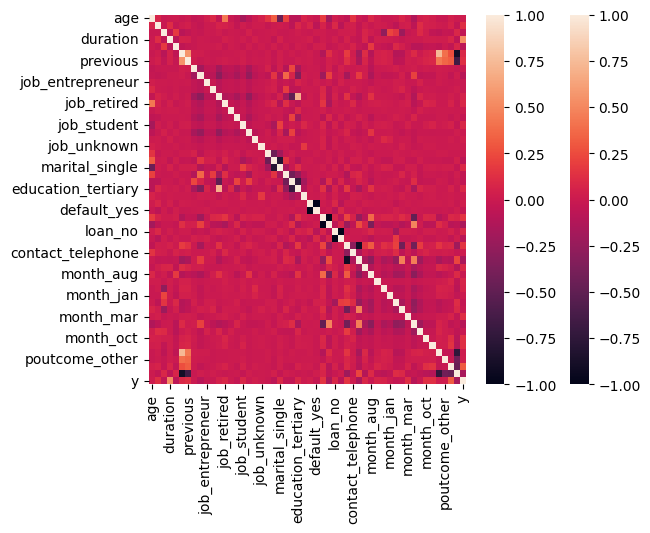

In [16]:
corr = train_with_dummies.corr()
sns.heatmap(corr)
sns.heatmap(corr[(corr>=0.5) | (corr<=-0.5)])

In [17]:
corr[(corr >= 0.5) | (corr <= -0.5)]

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.519283
campaign,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pdays,NaN,NaN,NaN,NaN,NaN,1.000000,0.561839,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.741590,NaN,NaN,-0.891223,NaN
previous,NaN,NaN,NaN,NaN,NaN,0.561839,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.657748,NaN
job_admin.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_blue-collar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_entrepreneur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, recall_score

# 1. Scale
cols_to_scale = ['balance', 'duration', 'pdays', 'previous']
scaler = StandardScaler()
train_with_dummies[cols_to_scale] = scaler.fit_transform(train_with_dummies[cols_to_scale])

# 2. Split
X = train_with_dummies.drop(columns='y')
y = train_with_dummies['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# 3. Model
model = LogisticRegression(max_iter=500, class_weight='balanced')
model.fit(X_train, y_train)

# 4. Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

AUC: 0.9428993078780739
Accuracy: 0.8692533333333333
Recall: 0.8783850590497116
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92    131795
           1       0.48      0.88      0.62     18205

    accuracy                           0.87    150000
   macro avg       0.73      0.87      0.77    150000
weighted avg       0.92      0.87      0.88    150000



In [24]:
test_with_dummies[cols_to_scale] = scaler.fit_transform(test_with_dummies[cols_to_scale])

y_test_pred = model.predict(test_with_dummies)

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['y'] = y_test_pred
submission.to_csv('submission.csv', index=False)
submission

,id,y
0,750000,0
1,750001,1
2,750002,0
3,750003,0
4,750004,0
...,...,...
249995,999995,0
249996,999996,0
249997,999997,1
249998,999998,0


### Non-linear models

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report

model = tree.DecisionTreeClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("AUC:", roc_auc)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

AUC: 0.9429054537656528
Accuracy: 0.90764
Recall: 0.6041197473221642
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95    131795
           1       0.62      0.60      0.61     18205

    accuracy                           0.91    150000
   macro avg       0.78      0.78      0.78    150000
weighted avg       0.91      0.91      0.91    150000



In [ ]:
y_test_pred = model.predict(test_with_dummies)

submission = pd.read_csv('sample_submission.csv')
submission['y'] = y_test_pred
submission.to_csv('submission.csv', index=False)
submission

,id,y
0,750000,0
1,750001,0
2,750002,0
3,750003,0
4,750004,0
...,...,...
249995,999995,0
249996,999996,0
249997,999997,0
249998,999998,0


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_test_pred = model.predict(test_with_dummies)

submission = pd.read_csv('sample_submission.csv')
submission['y'] = y_test_pred
submission.to_csv('submission.csv', index=False)

,id,y
0,750000,0
1,750001,0
2,750002,0
3,750003,0
4,750004,0
...,...,...
249995,999995,0
249996,999996,0
249997,999997,1
249998,999998,0


In [34]:
train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [39]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

categorical_columns = ['job','marital','education','default','housing','loan','contact','month','poutcome']

for i in categorical_columns:
  train[i] = train[i].astype('category')
  test[i] = test[i].astype('category')

X_train, X_test, y_train, y_test = train_test_split(train.iloc[:, :-1], train.y, random_state=42, test_size=0.2)

#model = XGBClassifier(n_estimators=300, scale_pos_weight=class_imbalance_ratio, use_label_encoder=False, eval_metric='logloss', random_state=42)
model = LGBMClassifier(n_estimators=300, class_weight='balanced', categorical_feature=categorical_columns, random_state=42)
model.fit(X_train, y_train)

y_test_pred = model.predict(test)

submission = pd.read_csv('sample_submission.csv')
submission['y'] = y_test_pred
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:3656: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  train_set.construct()
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:3656: UserWarning: categorical_feature in param dict is overridden.
  train_set.construct()


[LightGBM] [Warning] categorical_feature is set=job,marital,education,default,housing,loan,contact,month,poutcome, categorical_column=1,2,3,4,6,7,8,10,15 will be ignored. Current value: categorical_feature=job,marital,education,default,housing,loan,contact,month,poutcome
[LightGBM] [Info] Number of positive: 72283, number of negative: 527717
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1006
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

X_train, X_val, y_train, y_val = train_test_split(train.iloc[:, :-1], train.y, random_state=42, test_size=0.2)

categorical_columns = ['job','marital','education','default','housing','loan','contact','month','poutcome']
numerical_columns = [i for i in train.columns if i not in categorical_columns + ['y']]

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
])

In [47]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}

In [48]:
from sklearn.model_selection import cross_val_score
import numpy as np

for name, model in models.items():
  pipe = Pipeline([
      ('preprocessor', preprocessor),
      ('model', model)
  ])
  scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')
  print(f'{name}: Mean - {np.mean(scores)}, Std - {np.std(scores)}')

Logistic Regression: Mean - 0.7731595492758957, Std - 0.002484225525231023
Random Forest: Mean - 0.8271402979541138, Std - 0.0019417511526435953


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1682: UserWarning: [08:14:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self._Booster = train(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1682: UserWarning: [08:14:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self._Booster = train(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1682: UserWarning: [08:14:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self._Booster = train(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1682: UserWarning: [08:14:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self._Booster = train(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1682: UserWarning: [08:14:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not us

XGBoost: Mean - 0.8371463199687265, Std - 0.002353223637251769
[LightGBM] [Info] Number of positive: 57826, number of negative: 422174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120471 -> initscore=-1.987979
[LightGBM] [Info] Start training from score -1.987979


/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 57826, number of negative: 422174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120471 -> initscore=-1.987979
[LightGBM] [Info] Start training from score -1.987979


/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 57826, number of negative: 422174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120471 -> initscore=-1.987979
[LightGBM] [Info] Start training from score -1.987979


/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 57827, number of negative: 422173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120473 -> initscore=-1.987959
[LightGBM] [Info] Start training from score -1.987959


/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


[LightGBM] [Info] Number of positive: 57827, number of negative: 422173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120473 -> initscore=-1.987959
[LightGBM] [Info] Start training from score -1.987959


/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1108: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  X = _LGBMValidateData(


LightGBM: Mean - 0.8365360380142057, Std - 0.002240385768776708


In [54]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

xgb = XGBClassifier(learning_rate=0.05, objective='binary:logistic')

pipe = Pipeline([
      ('preprocessor', preprocessor),
      ('model', xgb)
])

params = {
        'model__min_child_weight': [1, 5, 10],
        'model__gamma': [0.5, 1],
        'model__subsample': [0.6],
        'model__colsample_bytree': [0.6],
        'model__max_depth': [3]
        }

rand_search = RandomizedSearchCV(
    pipe, params, scoring='roc_auc', random_state=42, cv=5, n_iter=20, n_jobs=-1, verbose=1
)

rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1951: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  evaluate_candidates(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'balance',
                                                                                'day',
                                                                                'duration',
                                                                                'campaign',
                                                                                'pdays',
                                                                                'previous']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder())]),
                                                                               ['job',
                                                                                'marital',
                                                                                'education',
                                                                                'default',
                                                                                'housing',
                                                                                'loan',
                                                                                'contact',
                                                                                'month',
                                                                                'poutc...
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.6],
                                        'model__gamma': [0.5, 1],
                                        'model__max_depth': [3],
                                        'model__min_child_weight': [1, 5, 10],
                                        'model__subsample': [0.6]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [55]:
from sklearn.metrics import classification_report

print(rand_search.cv_results_)

print(rand_search.best_estimator_)

print(rand_search.best_score_)

print(rand_search.best_params_)

{'mean_fit_time': array([17.67268977, 17.77401538, 17.75693688, 17.9190752 , 17.53737655,
       17.37235713]), 'std_fit_time': array([0.55966882, 0.68754122, 0.92473902, 0.69771079, 0.49894823,
       0.47991523]), 'mean_score_time': array([1.07081981, 1.08981228, 0.77325649, 0.95837941, 0.97379308,
       0.70531883]), 'std_score_time': array([0.39412055, 0.31890446, 0.03747625, 0.17666186, 0.24821934,
       0.11829084]), 'param_model__subsample': masked_array(data=[0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
             mask=[False, False, False, False, False, False],
       fill_value=1e+20), 'param_model__min_child_weight': masked_array(data=[1, 5, 10, 1, 5, 10],
             mask=[False, False, False, False, False, False],
       fill_value=999999), 'param_model__max_depth': masked_array(data=[3, 3, 3, 3, 3, 3],
             mask=[False, False, False, False, False, False],
       fill_value=999999), 'param_model__gamma': masked_array(data=[0.5, 0.5, 0.5, 1.0, 1.0, 1.0],
             mask=[F

In [56]:
y_pred_test = rand_search.best_estimator_.predict(test)

submission = pd.read_csv('sample_submission.csv')
submission['y'] = y_test_pred
submission.to_csv('submission.csv', index=False)